# Refined Stratified Sampling (RSS)

## Intoduction

This example file demonstrates how to generate samples using RSS class - see **section 6.3** in the accompanying paper "UQpy: A general purpose Python package and development environment for uncertainty quantification".

RSS requires STS, Krig and RunModel object, which enables UQpy to execute models in third-party software. The files necessary to run this example are:

1. The input template - 'abaqus_input.py'
2. The model script - 'abaqus_fire_analysis.py'
3. The output script - 'extract_abaqus_output.py'
4. The script used by the output script - 'abaqus_output_script.py'

Note: To execute the example in this notebook, it is necessary to have access to the finite element solver Abaqus.

## Description of the model

This example builds and analyzes a finite element model of a beam bearing uniformly distributed load, which is then subjected to fire load.

## The Script: 

Import the python modules used in this example and note down the start time.

In [1]:
from UQpy.RunModel import *
from UQpy.SampleMethods import VoronoiStrata, VoronoiSTS, VoronoiRSS
from UQpy.Surrogates import Kriging
from UQpy.Distributions import Uniform, Normal
import time
import os
import pickle
import glob
import matplotlib.pyplot as plt
import numpy as np
import mpl_toolkits.mplot3d.art3d as art3d
from scipy.spatial import Delaunay, Voronoi, voronoi_plot_2d

t = time.time()

## Building the model: 

There are two probabilistic input variables, the fire load density and the yield strength. The fire load density is denoted as 'qtd' and the yield strength is denoted as 'fy' in the template input script. These are different from the default variable names used by RunModel, and hence they must be passed in as one of the inputs while building the RunModel object.

In [2]:
var_names = ['qtd', 'fy']

### Create the model object: 

In [3]:
abaqus_sfe_model = RunModel(model_script='abaqus_fire_analysis.py', input_template='abaqus_input.py',
                            output_script='extract_abaqus_output.py', vec=False,
                            var_names=var_names, ntasks=1, model_dir='SFE_Example', verbose=False)
print('Example: Created the model object.')

Example: Created the model object.


### Generate samples from UQpy STS class: 

The fire load density is assumed to be uniformly distributed between 50 MJ/m^2 and 450 MJ/m^2. The yield strength is assumed to be normally distributed, with the parameters being: mean = 250 MPa and coefficient of variation of 7%.

In [4]:
marginals = [Uniform(loc=50, scale=400), Normal(loc=250e6, scale=0.07*250e6)]

print('Example: Created the distribution object')

Example: Created the distribution object


In [5]:
strata = VoronoiStrata(nseeds=15, dimension=2)
x_sts = VoronoiSTS(dist_object=marginals, strata_object=strata, nsamples_per_stratum=1, random_state=1)

print('Example: Created the STS samples')

Example: Created the STS samples


### Instantiate a UQpy Krig object: 

A Krig object is initiated with Linear regression model and Exponential correlation model. 

In [6]:
metamodel = Kriging(reg_model='Linear', corr_model='Exponential', n_opt=20, corr_model_params=np.ones(2), random_state=2)

print('Example: Created the Krig object.')

Example: Created the Krig object.


### Instantiate a UQpy RSS object: 

RSS class object is initiated using STS, RunModel and Krig objects.

In [7]:
rss = VoronoiRSS(runmodel_object=abaqus_sfe_model, sample_object=x_sts, krig_object=metamodel, random_state=3)

RSS object is executed to generate 85 more samples, such that number of total samples is 100.

In [8]:
rss.run(nsamples=100)

### Plot results: 

Results are loaded from the pickle dump. Krig method is used to evaluate structural fire model at the defined meshgrid.

In [9]:
sample_points = rss.samples.copy()
qois = rss.runmodel_object.qoi_list

ni = x_sts.samples.shape[0]
# Plot label font size
fs = 14
# Size of dots and cross in scatter plot
ss = 100

num, cov_yield = 250, 0.07
x1 = np.linspace(50, 450, num)
x2 = np.linspace((1-3*cov_yield)*250e6, (1+3*cov_yield)*250e6, num)
x1g_, x2g_ = np.meshgrid(x1, x2)
x1g, x2g = np.meshgrid(marginals[0].cdf(x1), marginals[1].cdf(x2))
x1gv, x2gv = x1g.reshape(x1g.size, 1), x2g.reshape(x2g.size, 1)

y2 = rss.krig_object.predict(np.concatenate([x1gv, x2gv], 1)).reshape(x1g.shape[0], x1g.shape[1])

This 3-D plot shows the structural fire model evaluate at the sample points. Also, green dots are the new samples generated using RSS class and black dots are samples generated using STS class.

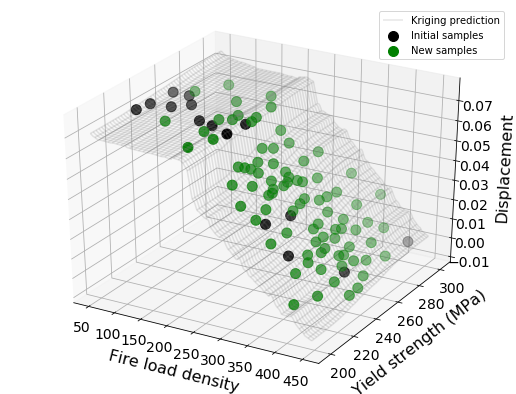

In [10]:

fig3 = plt.figure(figsize = (9, 7))
ax3 = plt.axes(projection='3d')
# Plot for estimated values
kr = ax3.plot_wireframe(x1g_, x2g_/1e06, y2, color='Grey', label='Kriging prediction', alpha=0.2)

# Plot for scattered data
ID1 = ax3.scatter3D(sample_points[:ni, 0], sample_points[:ni, 1]/1e06, np.atleast_2d(qois[:ni]), color='Black', label='Initial samples', s=ss)
ID2 = ax3.scatter3D(sample_points[ni:, 0], sample_points[ni:, 1]/1e06, np.atleast_2d(qois[ni:]), color='Green', label='New samples', s=ss)
ax3.set_xlabel('Fire load density', fontsize=fs+2)
ax3.set_ylabel('Yield strength (MPa)', fontsize=fs+2)
ax3.set_zlabel('Displacement', fontsize=fs+2)
plt.tick_params(axis='both', labelsize=fs, which='major')
ax3.yaxis.labelpad=10
ax3.xaxis.labelpad=10
ax3.zaxis.labelpad=10
plt.legend(handles=[kr, ID1, ID2])
plt.show()

The plot shows the Delaunay triangulation (Orange) and Voronoi cells (Black) of the final 100 samples.

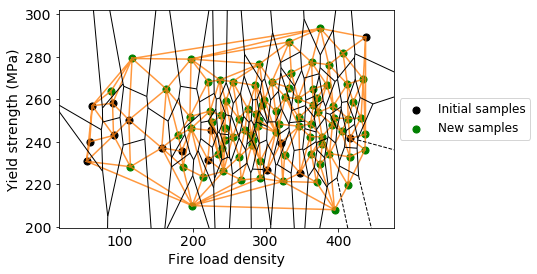

In [11]:
sample_points1 = sample_points.copy()
sample_points1[:, 1] = sample_points[:, 1]/1e06
vor = Voronoi(sample_points1)
fig = voronoi_plot_2d(vor, show_vertices=False, label='Voronoi', point_size=0.2)
plt.scatter(sample_points[:ni, 0], sample_points1[:ni, 1], label='Initial samples', color='Black', s=ss-50)
plt.scatter(sample_points[ni:, 0], sample_points1[ni:, 1], label='New samples', color='green', s=ss-50)
tri = Delaunay(sample_points1)
plt.tick_params(axis='both', labelsize=fs, which='major')
plt.xlabel('Fire load density', fontsize=fs)
plt.ylabel('Yield strength (MPa)', fontsize=fs)
plt.rc('legend', fontsize=fs-2)
fig2 = plt.triplot(sample_points1[:, 0], sample_points1[:, 1], tri.simplices, alpha=0.8)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [12]:
print('Example: Done!')
print('Time elapsed: %.2f minutes' % float((time.time() - t) / 60.0))

Example: Done!
Time elapsed: 132.56 minutes
